In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
import torch.nn as nn
import torchvision

#criando a classe para importação do dataset
class F1Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file, sep=';', engine='python')
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return image, y_label

C:\Users\arthu\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\arthu\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
torch.cuda.empty_cache()

In [3]:
import numpy as np

# Verifica se CUDA está disponível
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA indisponível! Treinando na CPU.')
else:
    print('CUDA Disponível! Trainando na GPU.')

CUDA Disponível! Trainando na GPU.


In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data

#numero de subprocessos utilizados para carregar os dados
num_workers = 0

#numero de samples por batch
batch_size = 29

#% do dataset de treino para validação
valid_size = 0.15

nClasses = 10

#transform para normalização e resize das imagens
transform_train = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize([256, 256]),
                                      transforms.RandomRotation(90),
                                      transforms.CenterCrop([224, 224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    
#criação do dataset    
train_dataset = F1Dataset(csv_file = 'equipes_f1_train.csv', root_dir = 'equipes_f1_train',
                   transform = transform_train)


test_size = int(0.15 * len(train_dataset))
train_size = len(train_dataset) - test_size

train_data, test_data = data.random_split(train_dataset, [train_size, test_size])


# Indices utilizados para validação
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# samplers para validação e treinamento
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# preparação dos dataloaders data
train_loader = DataLoader(train_data, batch_size=batch_size,
                          sampler=train_sampler, num_workers=num_workers)

valid_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=valid_sampler, num_workers=num_workers)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#nome das classes
classes = ('alpharomeo', 'alphatauri', 'alpine', 'astonmartin', 'ferrari', 'haas', 'mclaren', 'mercedes', 'redbull', 'williams')

In [5]:
print(len(train_data))
print(len(test_data))
print(len(train_data)+len(test_data))

1353
238
1591


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# desnormalizando a imagem
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0))) 

C:\Users\arthu\AppData\Local\Temp/ipykernel_11356/1241668073.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow 

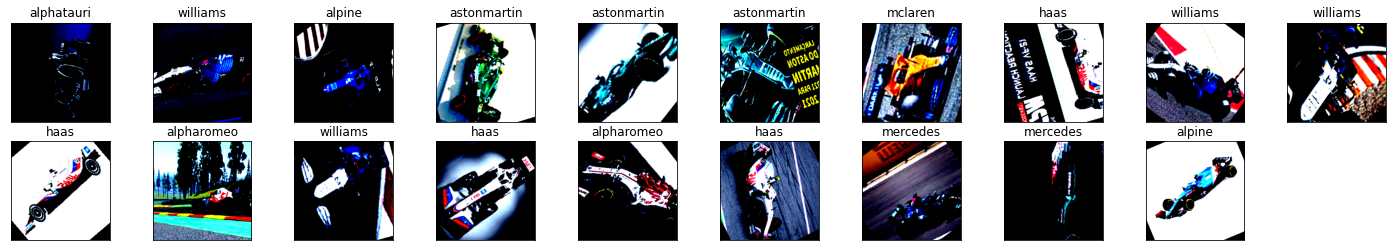

In [7]:
# obtendo um lote de imagens
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# mostrando as imagens com sua classe
fig = plt.figure(figsize=(25, 4))
# display 19 images
for idx in np.arange(19):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# arquitetura CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # camada convolucional
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(256)
        # camada de max pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12544, 500)
        self.fc1_bn = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # sequencia de camadas convolucionais e de max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv3_bn(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv4_bn(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.conv5_bn(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc1_bn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# definir a CNN
model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500

In [9]:
import torch.optim as optim

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [10]:
# numero de epocas para treinar o modelo
n_epochs = 60

valid_loss_min = np.Inf # monitorar variação na tava de validação

for epoch in range(1, n_epochs+1):

    # monitorar loss de treino e de validação
    train_loss = 0.0
    valid_loss = 0.0
    
    ######################
    # trainando o modelo #
    ######################
    model.train()
    for data, target in train_loader:
        # movendo os tensores para a GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # limpe os gradientes de todas as variáveis otimizadas
        optimizer.zero_grad()
        # forward pass: calcular saídas previstas passando entradas para o modelo
        output = model(data)
        # calcular a perda do lote
        loss = criterion(output, target)
        # backward pass: calcular o gradiente da perda em relação aos parâmetros do modelo
        loss.backward()
        # execute uma única etapa de otimização (atualização de parâmetro)
        optimizer.step()
        # atualizar training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validando o modelo #
    ######################
    model.eval()
    for data, target in valid_loader:
        # movendo os tensores para a GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: calcular saídas previstas passando entradas para o modelo
        output = model(data)
        # calcular a perda do lote
        loss = criterion(output, target)
        # atualizar a perda média de validação
        valid_loss += loss.item()*data.size(0)
    
    # perda média de teste
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # imprimir estatísticas de treinamento/validação
    print('Epoch: {} \tLoss de Treinamento: {:.6f} \tLoss de Validação: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # salvar modelo se a perda de validação diminuiu
    if valid_loss <= valid_loss_min:
        print('Loss de Validação caiu ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_f1.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Loss de Treinamento: 1.660509 	Loss de Validação: 0.254181
Loss de Validação caiu (inf --> 0.254181).  Saving model ...
Epoch: 2 	Loss de Treinamento: 1.208377 	Loss de Validação: 0.215161
Loss de Validação caiu (0.254181 --> 0.215161).  Saving model ...
Epoch: 3 	Loss de Treinamento: 0.964797 	Loss de Validação: 0.205597
Loss de Validação caiu (0.215161 --> 0.205597).  Saving model ...
Epoch: 4 	Loss de Treinamento: 0.845490 	Loss de Validação: 0.167141
Loss de Validação caiu (0.205597 --> 0.167141).  Saving model ...
Epoch: 5 	Loss de Treinamento: 0.749827 	Loss de Validação: 0.160858
Loss de Validação caiu (0.167141 --> 0.160858).  Saving model ...
Epoch: 6 	Loss de Treinamento: 0.684196 	Loss de Validação: 0.152767
Loss de Validação caiu (0.160858 --> 0.152767).  Saving model ...
Epoch: 7 	Loss de Treinamento: 0.659974 	Loss de Validação: 0.134604
Loss de Validação caiu (0.152767 --> 0.134604).  Saving model ...
Epoch: 8 	Loss de Treinamento: 0.598411 	Loss de Validação: 

In [10]:
model.load_state_dict(torch.load('model_f1.pt')) #carregar modelo já treinado

<All keys matched successfully>

In [16]:
# monitorar perda de teste
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterar sobre os dados de teste
for images, labels in test_loader:
    # movendo os tensores para a GPU
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    # forward pass: calcular saídas previstas passando entradas para o modelo
    output = model(images)
    # calcular a perda do lote
    loss = criterion(output, labels)
    # atualizar a perda de teste
    test_loss += loss.item()*images.size(0)
    # converter probabilidades de saída para classe prevista
    _, pred = torch.max(output, 1)    
    # comparar previsões com o rótulo verdadeiro
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calcular a precisão do teste para cada classe de objeto
    for i in range(len(images)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# perda média de teste
test_loss = test_loss/len(test_loader.dataset)
print('Loss de teste: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Precisão de Teste de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Precisão de Teste de %5s: N/A (no training examples)' % (classes[i]))

print('\nPrecisão de Teste (Geral): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Loss de teste: 0.087440

Precisão de Teste de alpharomeo: 93% (28/30)
Precisão de Teste de alphatauri: 91% (21/23)
Precisão de Teste de alpine: 100% (29/29)
Precisão de Teste de astonmartin: 95% (23/24)
Precisão de Teste de ferrari: 100% (18/18)
Precisão de Teste de  haas: 100% (25/25)
Precisão de Teste de mclaren: 100% (19/19)
Precisão de Teste de mercedes: 95% (19/20)
Precisão de Teste de redbull: 100% (20/20)
Precisão de Teste de williams: 96% (29/30)

Precisão de Teste (Geral): 97% (231/238)


C:\Users\arthu\AppData\Local\Temp/ipykernel_11356/3532043551.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow 

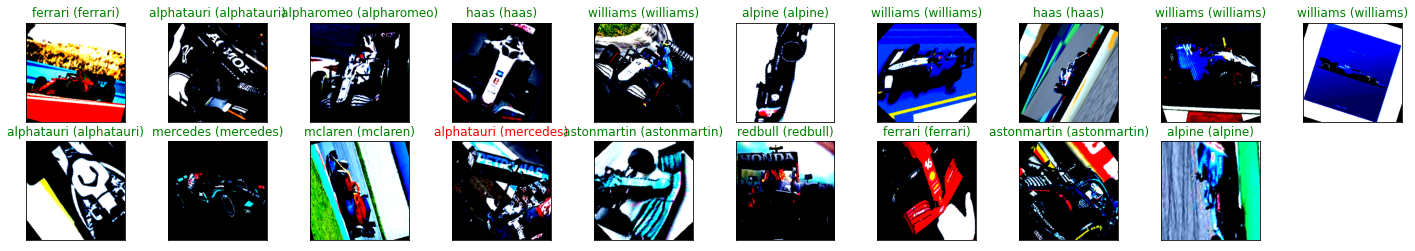

In [12]:
# obtem um lote de imagens de teste
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# mover os dados para a GPU
if train_on_gpu:
    images = images.cuda()

# obter saídas de amostra
output = model(images)
# converter probabilidades de saída para classe prevista
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# mover os dados de volta para a CPU
if train_on_gpu:
    images = images.cpu()

# plote as imagens no lote, juntamente com os rótulos previstos e verdadeiros
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(19):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score

# funçao geradora da matriz de confusão
def createCM(loader,model,nClasses):
    accuracy = 0
    CM = np.zeros((nClasses,nClasses))
    pred_array = []
    test_array = []
    
    with torch.no_grad():
    
      for sample_test, target_test in loader:
        
        if train_on_gpu:
            sample_test = sample_test.cuda()
        
        prediction = model(sample_test)
        outputsClass = torch.argmax(prediction, dim=1)
        
        if train_on_gpu:
            outputsClass = outputsClass.cpu()
            
        target_array = np.array([t.numpy() for t in target_test])
        predict_array = np.array([t.numpy() for t in outputsClass])

        for i in range(len(predict_array)):
          pred_array.append(predict_array.item(i))

        for i in range(len(target_array)):
          test_array.append(target_array.item(i))
    
    CM = confusion_matrix(test_array, pred_array)
    accuracy = accuracy_score(test_array, pred_array)
    return CM, accuracy

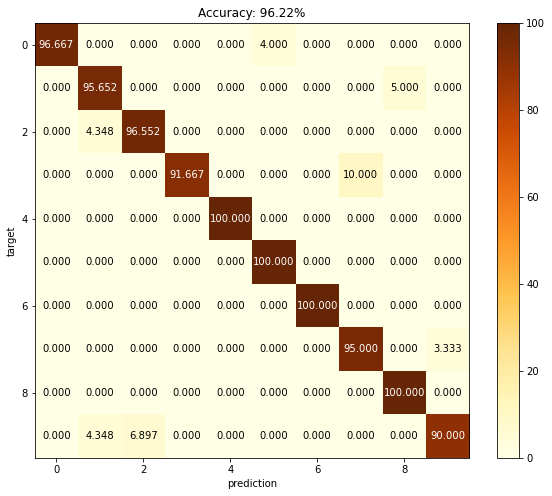

In [14]:
def plot_CM(CM,accuracy):
    CM = 100*CM/CM.sum(axis=1)
    plt.figure(figsize=(10,8))
    plt.imshow(CM,cmap='YlOrBr')
    plt.ylabel('target')
    plt.xlabel('prediction')
    plt.title('Accuracy: '+"{:4.2f}".format(accuracy*100)+'%')
    plt.colorbar()
    for i in range(CM.shape[0]):
        for j in range(CM.shape[1]):
            if CM[i,j]>70:
                color = "White"
            else:
                color = "Black"
            plt.text(j, i, "{:.3f}".format(CM[i,j]), ha="center", va="center", color=color)    

#plote matriz de confusão para os dados de teste 1
CM_train, accuracy_train = createCM(test_loader, model, nClasses)
plot_CM(CM_train, accuracy_train)

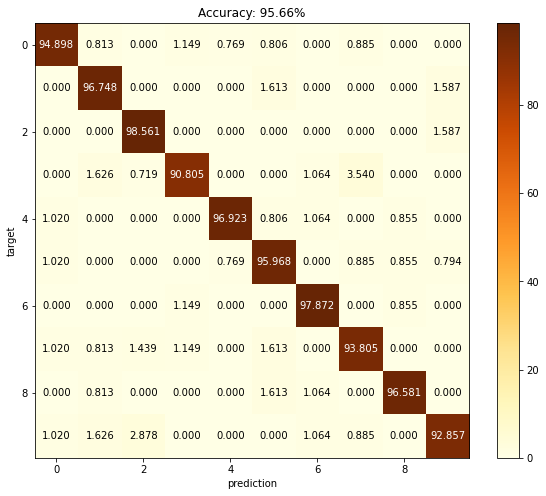

In [15]:
#plote matriz de confusão para os dados de treinamento
CM_test, accuracy_test = createCM(train_loader, model, 10)
plot_CM(CM_test, accuracy_test)